In [9]:
import numpy as np
from glob import glob
import os
import gc
from pathlib import Path
import yaml

from matplotlib import pyplot as plt
# from cycler import cycler
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('clarke-default')

from scipy.optimize import curve_fit
from scipy import stats

# plt.rcParams.update({'figure.dpi': 150})
# plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
#                                                       '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Load the config file and add new parameters

In [12]:
drive_path = '/Users/clarke/Data'
# drive_path = '/Volumes/LaCie/'

sphere_date = '20251212'
data_type = 'background'

base_path = f'{drive_path}/gas_collisions/pulse_calibration/sphere_{sphere_date}/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

config_dirs = glob(f'configs/sphere_{sphere_date}/*')

[print(i) for i in config_dirs]
print()

config_ind = 0

with open(config_dirs[config_ind] + '/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['calibrate'] = False

template = np.array(config['template'])
resolution = config['resolution']

for key in config.keys():
    print(key + ':\t ', config[key])

configs/sphere_20251212/20251215_p4e_5e-8mbar_d137khz_1
configs/sphere_20251212/20251215_p4e_5e-8mbar_d137khz_0
configs/sphere_20251212/20251215_p8e_5e-8mbar_d137khz_0
configs/sphere_20251212/20251215_p8e_5e-8mbar_d137khz_1

apply_notch:	  False
calibrate:	  False
d_sphere_nm:	  166.0
f_cutoff:	  [25000.0, 100000.0]
fit_window:	  0.1
keV_per_N:	  1.5898580411489077e+19
meters_per_volt:	  5.350582260798225e-08
resolution:	  98.11060054654384
search_window:	  5e-05
template:	  [-0.004063420440167591, -0.008439415724264942, -0.015643929002869362, -0.02294465927202532, -0.02584980746380044, -0.019819966720435435, -0.0022118981561332286, 0.023095735884378032, 0.04551490867338403, 0.05437125237566256, 0.049771829502444, 0.04250137207993088, 0.0423099479461935, 0.04640886233090658, 0.04449784886240424, 0.03178134503689269, 0.011094248696547135, -0.025202056678790715, -0.1064817645696615, -0.2559599301604328, -0.42858440645949936, -0.4863554774317835, -0.28083655971303395, 0.18706390093695843,

### List the background datasets

In [13]:
base_path = f'{drive_path}/gas_collisions/{data_type}_data/sphere_{sphere_date}/'

folders = glob(base_path + '*')

bkg_datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    bkg_datasets[folder.split(base_path)[-1]] = sub_datasets

20251216_unknown_6e-8mbar
	20251216_df
20251217_unknown_5e-8mbar_kryptonpumped
	20251217_df
20251216_unknown_5e-8mbar_cryopumped
	20251216_df
20251218_p8e_1e-7mbar_noinjection
	20251218_df
20251218_p8e_7e-8mbar_noinjection
	20251218_df
20251215_p8e_5e-8mbar
	20251215_df
20251216_unknown_6e-8mbar_cryopumped
	20251216_df


### Load a background dataset

In [21]:
reload(dp)

# choose which dataset to look at
dataset_ind = 2
dataset = list(bkg_datasets.keys())[dataset_ind]

plot = False

plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + bkg_datasets[dataset][0] if plot else None
nd = dp.NanoDataset(base_path + dataset + '/' + bkg_datasets[dataset][0], plot_path, verbose=True, max_files=10, \
                    config=config, ds_factor=10)
nd.load_search_data()
# nd.save_to_hdf5()

Loading files starting with
/Users/clarke/Data/gas_collisions/background_data/sphere_20251212/20251216_unknown_5e-8mbar_cryopumped/20251216_df
  Loading file 1...
  Loading file 2...
  Loading file 3...
  Loading file 4...
  Loading file 5...
  Loading file 6...
  Loading file 7...
  Loading file 8...
  Loading file 9...
  Loading file 10...


In [5]:
# nd2 = dp.NanoDataset()
# nd2.load_from_hdf5(base_path + dataset + '/' + bkg_datasets[dataset][0] + '_processed.hdf5')

### Cut away noisy periods

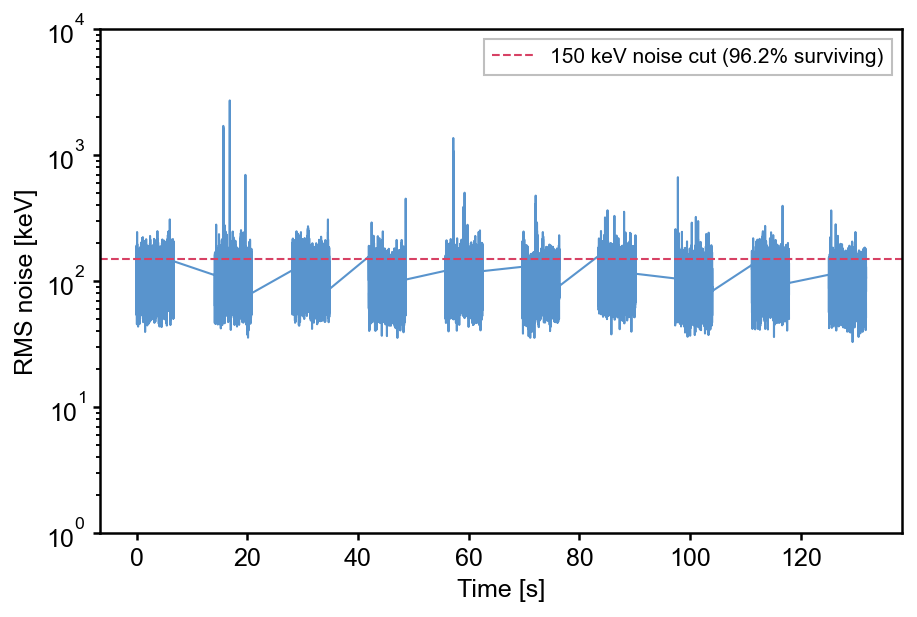

In [16]:
noise_thresh = 150 # keV

noise_mask = (nd.impulse_rms < noise_thresh) & (nd.impulse_rms > 10)

# also cut based on the fit to the resonance
res_mask = nd.resonance_params[:, 2] < 2*np.pi*100

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.semilogy(nd.pulse_times, nd.impulse_rms)
ax.axhline(noise_thresh, ls='--', color='C1', label='{:.0f} keV noise cut ({:.1f}% surviving)'\
                                                    .format(noise_thresh, 100*sum(noise_mask)/len(noise_mask)))
ax.set_xlabel('Time [s]')
ax.set_ylabel('RMS noise [keV]')
ax.set_ylim([1e0, 1e4])
ax.legend(loc='upper right')

### Cut based on goodness of fit

In [7]:
chi2_cut = 1.

# z_cut = 1
ndof = len(template) - 1
# alpha = (1 - stats.norm.cdf(z_cut))*2
# pvals = 1. - stats.chi2.cdf(nd.chi2, df=ndof)
chi2_mask = np.zeros(nd.chi2.shape, dtype=bool)
chi2_mask[nd.chi2 > chi2_cut] = True

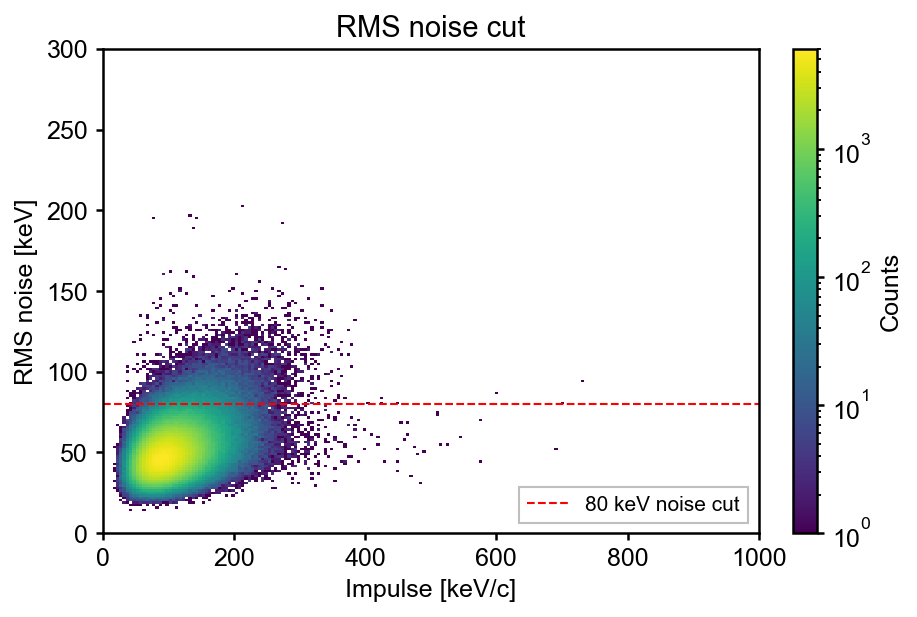

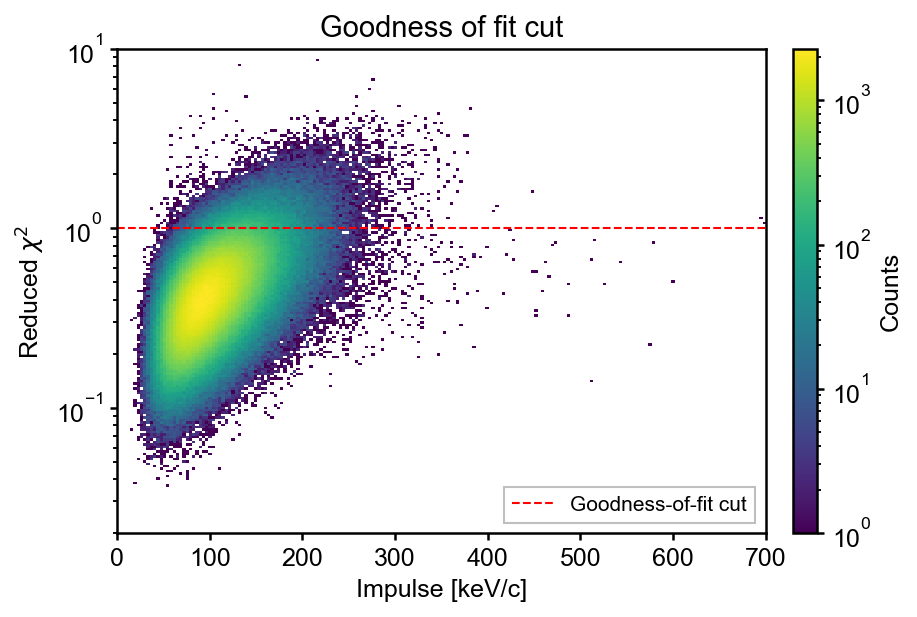

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.linspace(0, 300, 200)
bins_x = np.linspace(0, 1000, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.impulse_rms, bins=(bins_x, bins_y), norm='log')
ax.axhline(noise_thresh, ls='--', color='red', label='{:.0f} keV noise cut'.format(noise_thresh))
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('RMS noise [keV]')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('RMS noise cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.logspace(np.log10(2e-2), 1, 200)
bins_x = np.linspace(0, 700, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.chi2/ndof, bins=(bins_x, bins_y), norm='log')
ax.axhline(chi2_cut, ls='--', color='red', label='Goodness-of-fit cut')
ax.set_yscale('log')
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel(r'Reduced $\chi^2$')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('Goodness of fit cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

### Histogram the results

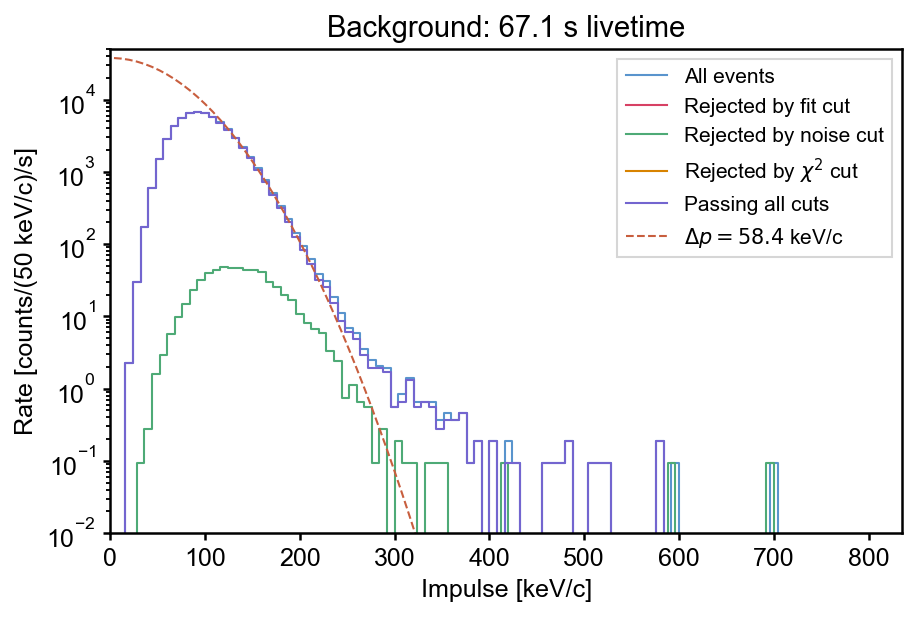

In [9]:
bin_edges = np.linspace(0, 800, 101)

counts_all, _ = np.histogram(nd.impulses, bins=bin_edges)
counts_acc, _ = np.histogram(nd.impulses[chi2_mask & noise_mask], bins=bin_edges)

bins = (bin_edges[1:] + bin_edges[:-1])/2.
bin_width = bin_edges[1] - bin_edges[0]  # keV/c per bin

# Compute total observation time: number of search windows * search window duration
total_time = len(nd.impulses) * nd.search_window  # seconds

# Scale to rate per 50 keV/c per second
scale_factor = (50. / bin_width) / total_time
rate_all = counts_all * scale_factor
rate_acc = counts_acc * scale_factor

ppb = len(nd.impulses)/len(bins)
exp = np.floor(np.log10(ppb))
coeff = 7*np.ceil(ppb/10**exp)

fit_ind = int(1.5*np.argmax(counts_all))

def half_gaus(x, A, sigma):
    return A*np.exp(-x**2/2/sigma**2)

p, _ = curve_fit(half_gaus, bins[fit_ind:], rate_acc[fit_ind:], p0=(rate_acc.max(), np.std(nd.impulses[~np.isnan(nd.impulses)])))

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.step(bins, rate_all, where='mid', label='All events')
ax.step(bins, np.histogram(nd.impulses[~res_mask], bins=bin_edges)[0] * scale_factor, label='Rejected by fit cut')
ax.step(bins, np.histogram(nd.impulses[~noise_mask & res_mask], bins=bin_edges)[0] * scale_factor, label='Rejected by noise cut')
ax.step(bins, np.histogram(nd.impulses[~chi2_mask & noise_mask & ~res_mask], bins=bin_edges)[0] * scale_factor, label=r'Rejected by $\chi^2$ cut')
ax.step(bins, rate_acc, where='mid', label='Passing all cuts')
ax.plot(bins, half_gaus(bins, *p), '--', label='$\\Delta p={:.1f}$ keV/c'.format(np.abs(p[1])))
ax.set_xlim([0, 1.05*np.amax(bins)])
ax.set_ylim([1e-2, 5e4])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Rate [counts/(50 keV/c)/s]')
ax.set_yscale('log')
ax.legend()
ax.set_title('Background: {:.1f} s livetime'.format(total_time))

if data_type == 'background':
    rate_bkg = np.copy(rate_acc)
    imp_spec_bkg = np.copy(bins)
    total_time_bkg = total_time

NameError: name 'imp_spec_bkg' is not defined

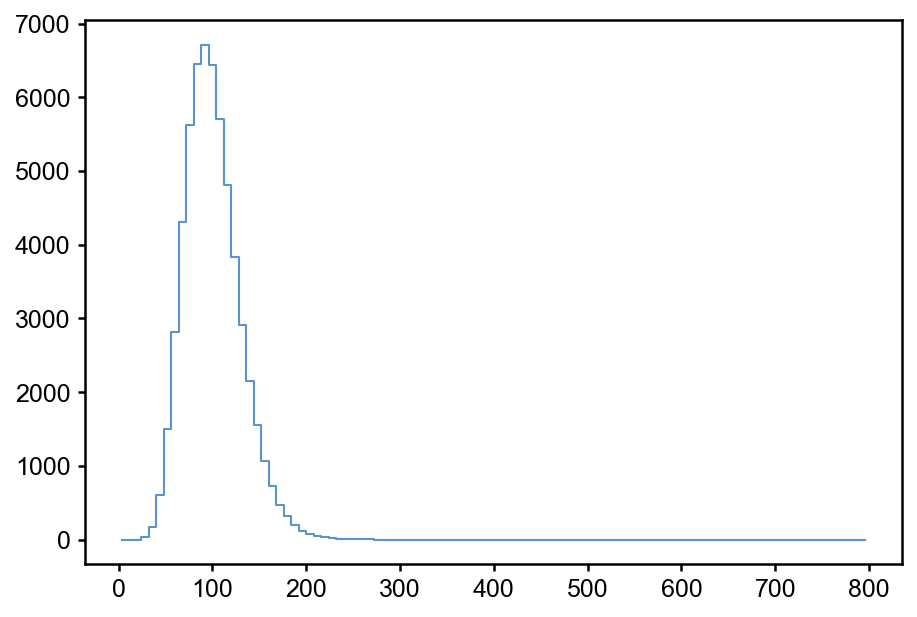

In [10]:
if data_type == 'xenon':
    from signal_models import gas_collision_spectrum
    
    # Signal model parameters (adjust as needed)
    sphere_temperature_K = 1000.  # Nanosphere temperature
    xe_partial_pressure_fraction = 0.02  # Xenon partial pressure fraction
    
    bin_edges = np.linspace(0, 800, 101)

    counts_all, _ = np.histogram(nd.impulses, bins=bin_edges)
    counts_acc, _ = np.histogram(nd.impulses[chi2_mask & noise_mask], bins=bin_edges)

    bins = (bin_edges[1:] + bin_edges[:-1])/2.
    bin_width = bin_edges[1] - bin_edges[0]  # keV/c per bin

    # Compute total observation time: number of search windows * search window duration
    total_time = len(nd.impulses) * nd.search_window  # seconds

    # Scale to rate per 50 keV/c per second
    scale_factor = (50 / bin_width) / total_time
    rate_all = counts_all * scale_factor
    rate_acc = counts_acc * scale_factor

    ppb = len(nd.impulses)/len(bins)
    exp = np.floor(np.log10(ppb))
    coeff = 7*np.ceil(ppb/10**exp)

    fit_ind = int(1.5*np.argmax(counts_all))

    def half_gaus(x, A, sigma):
        return A*np.exp(-x**2/2/sigma**2)

    p, _ = curve_fit(half_gaus, bins[fit_ind:], rate_acc[fit_ind:], p0=(rate_acc.max(), np.std(nd.impulses[~np.isnan(nd.impulses)])))

    # Compute signal model
    pressure_mbar = np.mean(nd.pressures) * xe_partial_pressure_fraction
    signal_spectrum = gas_collision_spectrum(bins, pressure_mbar, p[1],
                                             temperature_K=sphere_temperature_K,
                                             diameter_nm=config['d_sphere_nm'])

    fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
    ax.step(bins, rate_acc, where='mid', label='Xenon data')
    ax.step(imp_spec_bkg, rate_bkg, where='mid', label='Background')
    ax.plot(bins, signal_spectrum, '--', label='Signal model ({:.0f} K, {:.1e} mbar)'.format(sphere_temperature_K, pressure_mbar))
    ax.plot(bins, half_gaus(bins, *p), '--', label='Background model ($\\Delta p={:.1f}$ keV/c)'.format(np.abs(p[1])))
    ax.set_xlim([0, 1.05*np.amax(bins)])
    ax.set_ylim([1e-3, 5e4])
    ax.set_xlabel('Impulse [keV/c]')
    ax.set_ylabel('Rate [counts/(50 keV/c)/s]')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title('Xenon: {:.1f} s livetime'.format(total_time))

In [11]:
# Fit for best xenon pressure at two temperatures
from scipy.optimize import minimize_scalar, minimize

# Compute excess spectrum (xenon - background)
excess_spectrum = rate_acc - rate_bkg

# Only consider bins above 4 sigma from zero (using half-gaussian sigma)
sigma_fit = np.abs(p[1])
threshold = 4 * sigma_fit

# Also require positive excess to avoid negative values driving the fit
fit_mask = (bins > threshold) & (excess_spectrum > 0)

print(f"Fit threshold: {threshold:.1f} keV/c")
print(f"Number of bins in fit region: {np.sum(fit_mask)}")
print(f"Bins with positive excess: {np.sum((bins > threshold) & (excess_spectrum > 0))} / {np.sum(bins > threshold)}")
print(f"Mean excess in fit region: {np.mean(excess_spectrum[fit_mask]):.2e}")
print(f"Measured pressure from gauge: {np.mean(nd.pressures):.2e} mbar")
print(f"Sphere diameter: {config['d_sphere_nm']} nm")
print(f"Resolution: {resolution:.1f} keV/c")
print()

# Test the model at a known pressure to check scaling
test_pressure = 1e-9  # mbar
test_spectrum = gas_collision_spectrum(bins, test_pressure, resolution,
                                       temperature_K=293.,
                                       diameter_nm=config['d_sphere_nm'])
print(f"Model output at P={test_pressure:.0e} mbar, T=293K:")
print(f"  Max value: {np.max(test_spectrum):.2e}")
print(f"  Value at 300 keV/c: {test_spectrum[np.argmin(np.abs(bins-300))]:.2e}")
print()

# Simple linear fit: since spectrum scales linearly with pressure,
# find the best scaling factor
def fit_pressure_linear(temperature_K):
    # Get model at unit pressure (1 mbar)
    unit_model = gas_collision_spectrum(bins[fit_mask], 1.0, resolution,
                                        temperature_K=temperature_K,
                                        diameter_nm=config['d_sphere_nm'])
    
    # Linear least squares: excess = pressure * unit_model
    # Best pressure = sum(excess * model) / sum(model^2)
    data = excess_spectrum[fit_mask]
    
    # Weighted least squares
    weights = 1.0 / (np.sqrt(counts_acc[fit_mask] + 1) * scale_factor + 1e-10)
    
    numerator = np.sum(weights**2 * data * unit_model)
    denominator = np.sum(weights**2 * unit_model**2)
    
    best_pressure = numerator / denominator
    
    # Compute chi2
    model_at_best = best_pressure * unit_model
    chi2 = np.sum((weights * (data - model_at_best))**2)
    ndof = np.sum(fit_mask) - 1
    
    return best_pressure, chi2, ndof

# Fit at both temperatures
pressure_293K, chi2_293K, ndof_293K = fit_pressure_linear(293.)
pressure_1000K, chi2_1000K, ndof_1000K = fit_pressure_linear(1000.)

print(f"Best-fit results (linear method):")
print(f"  T = 293 K:  P_Xe = {pressure_293K:.3e} mbar, chi2/ndof = {chi2_293K:.1f}/{ndof_293K}")
print(f"  T = 1000 K: P_Xe = {pressure_1000K:.3e} mbar, chi2/ndof = {chi2_1000K:.1f}/{ndof_1000K}")
print()

# Compute best-fit spectra
spectrum_293K = gas_collision_spectrum(bins, pressure_293K, resolution,
                                       temperature_K=293.,
                                       diameter_nm=config['d_sphere_nm'])
spectrum_1000K = gas_collision_spectrum(bins, pressure_1000K, resolution,
                                        temperature_K=1000.,
                                        diameter_nm=config['d_sphere_nm'])

# Plot results
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.step(bins, rate_acc, where='mid', label='Xenon data')
ax.step(imp_spec_bkg, rate_bkg, where='mid', label='Background')
# ax.plot(bins, signal_spectrum, label='Signal model ({:.0f} K, {:.1e} mbar)'.format(sphere_temperature_K, pressure_mbar))
ax.plot(bins, half_gaus(bins, *p), '--', label='$\\Delta p={:.1f}$ keV/c'.format(np.abs(p[1])))
ax.step(bins[fit_mask], excess_spectrum[fit_mask], where='mid', label='Background subtracted')
ax.axvline(threshold, ls=':', color='gray', label='$4\\sigma$ threshold ({:.0f} keV/c)'.format(threshold))
# ax.plot(bins, spectrum_293K, '-', color='C0', 
#         label='$T=293$ K, $P_{{Xe}}={:.2e}$ mbar'.format(pressure_293K))
ax.plot(bins, spectrum_1000K, '--', 
        label='$T=1000$ K, $P_{{Xe}}={:.2e}$ mbar'.format(pressure_1000K))

ax.set_xlim([0, 1.05*np.amax(bins)])
ax.set_ylim([1e-2, 5e4])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Rate [counts/(50 keV/c)/s]')
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=9)
ax.set_title('Best-fit Xe pressure (fit region: $q > {:.0f}$ keV/c)'.format(threshold))

NameError: name 'rate_bkg' is not defined